In [1]:
import sys
sys.path.append('C:/Users/13447/Documents/GitHub/master_thesis')

In [3]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
import scipy.sparse as sp
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df, threshold_interactions_df_plus, train_test_split_csr

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree import Tree

In [4]:

my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)

def load_user_item_matrix(filepath):
    data = []

    with open(filepath, 'r') as f:
        while True:
            user_line = f.readline()
            if not user_line:
                break

            user_line = user_line.strip()
            if '|' not in user_line:
                continue

            user_id, num_ratings = user_line.split('|')
            user_id = int(user_id)
            num_ratings = int(num_ratings)

            for _ in range(num_ratings):
                item_line = f.readline().strip()
                parts = item_line.split('\t')
                if len(parts) < 2:
                    continue
                item_id, score = parts[0], parts[1]
                data.append([user_id, int(item_id), int(score)])

    df = pd.DataFrame(data, columns=['user_id', 'item_id', 'rating'])
    return df


In [5]:
def safe_int(x):
    return int(x) if x != 'None' else 0


def load_track_data(filepath):
    track_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('|')
            track_id = safe_int(parts[0])
            album_id = safe_int(parts[1])
            artist_id = safe_int(parts[2])
            genre_ids = [safe_int(g) for g in parts[3:]] if len(parts) > 3 else []
            track_data.append([track_id, album_id, artist_id, genre_ids])
    return pd.DataFrame(track_data, columns=['track_id', 'album_id', 'artist_id', 'genre_ids'])

def load_album_data(filepath):
    album_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('|')
            album_id = safe_int(parts[0])
            artist_id = safe_int(parts[1])
            genre_ids = [safe_int(g) for g in parts[2:]] if len(parts) > 2 else []
            album_data.append([album_id, artist_id, genre_ids])
    return pd.DataFrame(album_data, columns=['album_id', 'artist_id', 'genre_ids'])


# read artistData2
def load_artist_data(filepath):
    with open(filepath, 'r') as f:
        artist_ids = [int(line.strip()) for line in f]
    return pd.DataFrame(artist_ids, columns=['artist_id'])

# read genreData2
def load_genre_data(filepath):
    with open(filepath, 'r') as f:
        genre_ids = [int(line.strip()) for line in f]
    return pd.DataFrame(genre_ids, columns=['genre_id'])

In [6]:
track_df = load_track_data('D:/dataset/ydata-ymusic-kddcup-2011-track2/ydata-ymusic-kddcup-2011-track2/trackData2.txt')
track_df

,track_id,album_id,artist_id,genre_ids
0,1,106710,281667,"[214765, 162234, 155788]"
1,2,280977,233685,"[131552, 173467, 48505]"
2,3,38422,219136,"[61215, 201738, 88853]"
3,4,119529,166863,"[17453, 35389]"
4,5,16742,294690,"[61215, 34486, 274088]"
...,...,...,...,...
224036,296100,166516,33011,"[274088, 199606, 88853]"
224037,296101,0,0,[]
224038,296102,153644,289056,"[158282, 139095, 242383]"
224039,296105,68336,6613,[82064]


In [11]:
album_df = load_album_data('D:/dataset/ydata-ymusic-kddcup-2011-track2/ydata-ymusic-kddcup-2011-track2/albumData2.txt')
album_df

,album_id,artist_id,genre_ids
0,0,0,[214765]
1,6,228091,"[158282, 81520, 242383]"
2,19,85028,[103715]
3,30,16832,[31567]
4,33,26330,"[149962, 209270]"
...,...,...,...
52824,296104,125866,[158282]
52825,296106,221637,"[116130, 9432]"
52826,296107,0,[61215]
52827,296108,93277,[61215]


In [13]:
artist_df = load_artist_data('D:/dataset/ydata-ymusic-kddcup-2011-track2/ydata-ymusic-kddcup-2011-track2/artistData2.txt')
artist_df

,artist_id
0,16
1,23
2,35
3,40
4,49
...,...
18669,295987
18670,296007
18671,296012
18672,296013


In [15]:
genre_df = load_genre_data('D:/dataset/ydata-ymusic-kddcup-2011-track2/ydata-ymusic-kddcup-2011-track2/genreData2.txt')
genre_df

,genre_id
0,208
1,315
2,642
3,1075
4,1271
...,...
562,292093
563,293670
564,293688
565,294138


In [17]:
train_path = 'D:/dataset/ydata-ymusic-kddcup-2011-track2/ydata-ymusic-kddcup-2011-track2/trainIdx2.txt'
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
train_df = load_user_item_matrix(train_path)


In [18]:
train_df

,user_id,item_id,rating
0,0,28341,90
1,0,51210,90
2,0,79500,90
3,0,82317,90
4,0,98399,90
...,...,...,...
61944401,249011,270557,90
61944402,249011,273574,90
61944403,249011,286938,90
61944404,249011,287681,80


In [10]:
duplicate_counts = train_df.groupby(['user_id', 'item_id']).size()
duplicates = duplicate_counts[duplicate_counts > 1]

print(f"🔁 Number of duplicated (user_id, item_id) pairs: {len(duplicates)}")
print(duplicates.head())


🔁 Number of duplicated (user_id, item_id) pairs: 0
Series([], dtype: int64)


In [68]:
print(train_df['item_id'].max())      # highest item_id
print(track_df['track_id'].max())     # highest track_id
print(train_df['item_id'].isin(track_df['track_id']).mean())  # proportion to match

print(train_df['item_id'].isin(album_df['album_id']).mean())

print(train_df['item_id'].isin(artist_df['artist_id']).mean())

print(train_df['item_id'].isin(genre_df['genre_id']).mean())



296110
296110
0.4385845107627636
0.1925648621120041
0.3114063600835885
0.05744426704164376


In [21]:
def build_item_metadata(track_df, album_df, artist_df, genre_df):
    rows = []

    # 1. Tracks
    for _, row in track_df.iterrows():
        rows.append({
            'item_id': row['track_id'],
            'item_type': 'track',
            'artist_id': row['artist_id'],
            'genre_ids': row['genre_ids']
        })

    # 2. Albums
    for _, row in album_df.iterrows():
        rows.append({
            'item_id': row['album_id'],
            'item_type': 'album',
            'artist_id': row['artist_id'],
            'genre_ids': row['genre_ids']
        })

    # 3. Artists
    for artist_id in artist_df['artist_id']:
        rows.append({
            'item_id': artist_id,
            'item_type': 'artist',
            'artist_id': artist_id,
            'genre_ids': 0
        })

    # 4. Genres
    for genre_id in genre_df['genre_id']:
        rows.append({
            'item_id': genre_id,
            'item_type': 'genre',
            'artist_id': 0,
            'genre_ids': [genre_id]
        })

    return pd.DataFrame(rows)

In [23]:
item_meta_df = build_item_metadata(track_df, album_df, artist_df, genre_df)

train_with_meta = train_df.merge(item_meta_df, on='item_id', how='inner')

# When loading the data, sort by a stable column (e.g., user_id)
train_with_meta = train_with_meta.sort_values('user_id').reset_index(drop=True)

train_with_meta

,user_id,item_id,rating,item_type,artist_id,genre_ids
0,0,28341,90,artist,28341,0
1,0,161823,30,artist,161823,0
2,0,79500,90,artist,79500,0
3,0,182018,70,artist,182018,0
4,0,180487,90,artist,180487,0
...,...,...,...,...,...,...
61944401,249011,131552,80,genre,0,[131552]
61944402,249011,286938,90,artist,286938,0
61944403,249011,287681,80,genre,0,[287681]
61944404,249011,252215,80,genre,0,[252215]


In [198]:
df = train_with_meta.copy()

# Filter: keep only artist & genre (drop album, track)
df = df[~df['item_type'].isin(['album', 'track'])].copy()

print(f"🎯 Sample shape: {df.shape}")
print(f"👤 Users: {df['user_id'].nunique()}, 🎵 Items: {df['item_id'].nunique()}")

🎯 Sample shape: (22848233, 6)
👤 Users: 248344, 🎵 Items: 19241


In [200]:
filtered_df = threshold_interactions_df(df,'user_id','item_id',100,500)

Starting interactions info
Number of rows: 248344
Number of cols: 19241
Sparsity: 0.478%
Ending interactions info
Number of rows: 4644
Number of columns: 8938
Sparsity: 10.674%


In [202]:
# filtered_df = threshold_interactions_df_plus(df, min_items_per_user=500, min_artists_per_user=20, min_genres_per_user=10,min_users_per_item=150)
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
sampled_users = np.random.choice(filtered_df['user_id'].unique(), size=2000, replace=False)
sampled_df = filtered_df[filtered_df['user_id'].isin(sampled_users)]
print(f"🎯 Sample shape: {sampled_df.shape}")
print(f"👤 Users: {sampled_df['user_id'].nunique()}, 🎵 Items: {sampled_df['item_id'].nunique()}")
filtered_df = threshold_interactions_df(sampled_df,'user_id','item_id',100,500)

🎯 Sample shape: (1941009, 6)
👤 Users: 2000, 🎵 Items: 8938
Starting interactions info
Number of rows: 2000
Number of cols: 8938
Sparsity: 10.858%
Ending interactions info
Number of rows: 1701
Number of columns: 5011
Sparsity: 17.890%


In [204]:
all_user_ids = sorted(filtered_df['user_id'].unique().tolist())
filtered_df

,user_id,item_id,rating,item_type,artist_id,genre_ids
1041,9,238709,0,artist,238709,0
1042,9,169510,0,artist,169510,0
1047,9,208084,70,artist,208084,0
1049,9,245398,0,artist,245398,0
1052,9,153166,0,artist,153166,0
...,...,...,...,...,...,...
61933962,248947,83754,30,artist,83754,0
61933963,248947,141799,0,genre,0,[141799]
61933966,248947,141677,0,artist,141677,0
61933967,248947,262458,0,artist,262458,0


In [232]:
# item type map
item_type_map = filtered_df.drop_duplicates(subset='item_id')[['item_id', 'item_type']]
item_type_map = dict(zip(item_type_map['item_id'], item_type_map['item_type']))


In [234]:
def get_item_type(item_id):
    return item_type_map.get(item_id, 'unknown')  


In [236]:
print(get_item_type(238709))  
print(get_item_type(141799))  


artist
genre


In [44]:
all_user_ids = sorted(filtered_df['user_id'].unique().tolist())

def split_users_by_ratio(all_user_ids, ratio):
    n = len(all_user_ids)
    split_point = int(n * ratio)
    warm_users = all_user_ids[:split_point]
    cold_users = all_user_ids[split_point:]
    return warm_users, cold_users

# Example ratios from 10% to 50%
# ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
# splits = {r: split_users_by_ratio(all_user_ids, r) for r in ratios}


## 10% warm

In [46]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.1)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")



In [48]:
df_warm

,user_id,item_id,rating,item_type,artist_id,genre_ids
1041,9,238709,0,artist,238709,0
1042,9,169510,0,artist,169510,0
1047,9,208084,70,artist,208084,0
1049,9,245398,0,artist,245398,0
1052,9,153166,0,artist,153166,0
...,...,...,...,...,...,...
6037088,24286,253660,30,artist,253660,0
6037092,24286,293466,10,artist,293466,0
6037095,24286,178994,90,artist,178994,0
6037096,24286,219001,0,artist,219001,0


In [50]:
df_cold

,user_id,item_id,rating,item_type,artist_id,genre_ids
6058372,24414,267421,0,artist,267421,0
6058376,24414,279057,0,artist,279057,0
6058388,24414,60300,30,artist,60300,0
6058393,24414,121430,0,artist,121430,0
6058396,24414,164412,30,artist,164412,0
...,...,...,...,...,...,...
61933962,248947,83754,30,artist,83754,0
61933963,248947,141799,0,genre,0,[141799]
61933966,248947,141677,0,artist,141677,0
61933967,248947,262458,0,artist,262458,0


In [52]:
def split_and_combine(strategy="artist-only"):
    """Handles both approaches with proper matrix alignment"""
    # Get full cold matrix and mappings
    matrix_cold, rid_to_idx_cold, _, cid_to_idx, _ = df_to_matrix(
        df_cold, "user_id", "item_id", "rating"
    )
    matrix_cold = matrix_cold.tocsr()

    # Create boolean masks
    artist_mask = np.isin(
        np.arange(matrix_cold.shape[1]), 
        [cid_to_idx[iid] for iid in df_cold[df_cold['item_type'] == 'artist']['item_id']]
    )
    genre_mask = ~artist_mask

    # Create aligned matrices
    matrix_cold_artist = matrix_cold.multiply(artist_mask)
    matrix_cold_genre = matrix_cold.multiply(genre_mask)
    matrix_cold_artist = matrix_cold.multiply(artist_mask).tocsr()
    matrix_cold_genre = matrix_cold.multiply(genre_mask).tocsr()

    al_artist, test_cold, _ = train_test_split(
        matrix_cold_artist, 
        split_count=30,
        fraction=None
    )
    
    if strategy == "artist-only":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)  
        return K_cold, X_cold, test_cold
    
    elif strategy == "hybrid":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)
        X_cold = X_cold + matrix_cold_genre
        return K_cold, X_cold, test_cold


In [54]:
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)

train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")


In [124]:
def check_rating_distribution(train, X):
    def sparse_to_rating_list(matrix):
        cx = matrix.tocoo()
        return cx.data
    
    r_train = sparse_to_rating_list(train)
    r_X = sparse_to_rating_list(X)
    
    print("Cold_K Ratings:")
    print(pd.Series(r_train).describe())
    
    print("\nCold_X Ratings:")
    print(pd.Series(r_X).describe())

check_rating_distribution(train_cold_K_artist, X_cold_artist)


Cold_K Ratings:
count    692.000000
mean      55.524566
std       25.349099
min        2.000000
25%       30.000000
50%       50.000000
75%       80.000000
max      100.000000
dtype: float64

Cold_X Ratings:
count    1.333647e+06
mean     2.235686e+01
std      3.142817e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+01
max      1.000000e+02
dtype: float64


In [150]:
def check_positive_rating_distribution(X):
    cx = X.tocoo()
    ratings = cx.data
    ratings = ratings[ratings > 0]  # ❗ 只保留有效评分
    print(pd.Series(ratings).describe())

check_positive_rating_distribution(X_cold_artist)

count    536834.000000
mean         55.540731
std          24.713181
min           1.000000
25%          30.000000
50%          50.000000
75%          70.000000
max         100.000000
dtype: float64


In [55]:
train_cold_K_artist

<1531x5011 sparse matrix of type '<class 'numpy.float64'>'
	with 692 stored elements in Compressed Sparse Row format>

In [108]:
traincoldK_df_artist = matrix_to_df(train_cold_K_artist,idx_to_rid_cold,idx_to_cid)
traincoldK_df_artist

,user_id,item_id,rating
0,24469,51596,50.0
1,24737,85479,90.0
2,24774,15975,50.0
3,25042,11616,50.0
4,25161,176799,30.0
...,...,...,...
687,247178,288893,50.0
688,247905,191351,70.0
689,248092,256345,30.0
690,248121,84211,90.0


In [102]:
train_cold_full_artist=train_cold_K_artist+X_cold_artist

In [106]:
traincoldfull_df_artist = matrix_to_df(train_cold_full_artist,idx_to_rid_cold,idx_to_cid)
traincoldfull_df_artist

,user_id,item_id,rating
0,24414,208084,30.0
1,24414,153166,30.0
2,24414,185075,30.0
3,24414,57021,50.0
4,24414,70636,30.0
...,...,...,...
537521,248947,27818,30.0
537522,248947,159190,30.0
537523,248947,248231,30.0
537524,248947,1936,30.0


In [110]:
testcold_df_artist = matrix_to_df(test_cold_artist,idx_to_rid_cold,idx_to_cid)
testcold_df_artist

,user_id,item_id,rating
0,24414,64226,50.0
1,24414,119678,30.0
2,24414,193575,30.0
3,24414,180364,30.0
4,24414,175781,70.0
...,...,...,...
20294,248947,22521,30.0
20295,248947,154157,30.0
20296,248947,1589,30.0
20297,248947,285717,30.0


In [62]:
train_copy_artist = (train_cold_K_artist.tolil()).copy()

coldK_df_artist = matrix_to_full_df(train_copy_artist, idx_to_rid_cold, idx_to_cid)
coldK_df_artist

,238709,169510,208084,245398,153166,257965,31321,79867,185075,35899,...,275477,126760,203794,84071,42783,150884,171378,71326,111572,241362
24414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
X_cold_artist

<1531x5011 sparse matrix of type '<class 'numpy.float64'>'
	with 1333647 stored elements in Compressed Sparse Row format>

In [66]:
test_cold_artist

<1531x5011 sparse matrix of type '<class 'numpy.float64'>'
	with 20299 stored elements in Compressed Sparse Row format>

In [64]:
X_copy_artist = (X_cold_artist.tolil()).copy()

coldX_df_artist = matrix_to_full_df(X_copy_artist, idx_to_rid_cold, idx_to_cid)
coldX_df_artist

,238709,169510,208084,245398,153166,257965,31321,79867,185075,35899,...,275477,126760,203794,84071,42783,150884,171378,71326,111572,241362
24414,0.0,0.0,30.0,0.0,30.0,0.0,0.0,0.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248269,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248803,30.0,0.0,0.0,0.0,30.0,50.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [322]:
# shape of test_cold

print(f"Cold users in X: {len(np.unique(X_cold_artist.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_artist.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_artist.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_artist.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_artist.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_artist.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_artist.shape}")
print(f"Shape of train_cold: {train_cold_K_artist.shape}")
print(f"Shape of X_cold: {X_cold_artist.shape}")

Cold users in X: 1531
Cold items in X: 4793
test users in test: 1479
test items in test: 3898
train users in train: 692
train items in train: 574
-------------------
Shape of test_cold: (1531, 5011)
Shape of train_cold: (1531, 5011)
Shape of X_cold: (1531, 5011)


In [323]:
print(f"Cold users in X: {len(np.unique(X_cold_hybrid.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_hybrid.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_hybrid.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_hybrid.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_hybrid.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_hybrid.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_hybrid.shape}")
print(f"Shape of train_cold: {train_cold_K_hybrid.shape}")
print(f"Shape of X_cold: {X_cold_hybrid.shape}")

Cold users in X: 1531
Cold items in X: 5011
test users in test: 1475
test items in test: 3980
train users in train: 689
train items in train: 587
-------------------
Shape of test_cold: (1531, 5011)
Shape of train_cold: (1531, 5011)
Shape of X_cold: (1531, 5011)


In [ ]:
print (X_cold_hybrid)

In [384]:
train_df = matrix_to_df_2(train_cold_K_hybrid,idx_to_rid_cold,idx_to_cid)
train_copy = (train_cold_K_hybrid.tolil()).copy()
warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

In [386]:
x_df

,238709,169510,208084,245398,153166,257965,31321,79867,185075,35899,...,275477,126760,203794,84071,42783,150884,171378,71326,111572,241362
9,0.0,0.0,70.0,0.0,0.0,90.0,50.0,70.0,0.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217,0.0,0.0,0.0,30.0,0.0,70.0,90.0,0.0,0.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
510,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cold users in X: 1531
Cold items in X: 4793
test users in test: 1478
test items in test: 3907
train users in train: 666
train items in train: 571
-------------------
Shape of test_cold: (1531, 5011)
Shape of train_cold: (1531, 5011)
Shape of X_cold: (1531, 5011)

In [46]:
from collections import defaultdict


def elicitation_by_tree_path_retrain_skiped_warm(Tree, train, test, X, matrix_warm, idx_to_rid_cold, idx_to_rid_warm, idx_to_cid, iteration=5):
    """
    Method 3 (revised): Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (stored in asked_items), go deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - tree_model_class: class of the decision tree model (not instance)
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - idx_to_rid, idx_to_cid: index-to-ID mapping
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    asked_items = {u: set() for u in range(num_users)}  

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")
        # Retrain tree using current train_copy
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

        pct = Tree(max_depth=i + 1, min_instances=5)
        pct.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = pct.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]

                if item_idx in asked_items[u]:
                    # Already asked, go deeper based on user's rating
                    rating = train_copy[u, item_idx]
                    if rating > 50:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked item: try to add it to training
                asked_items[u].add(item_idx)  
                rating = X_copy[u, item_idx]
                if rating > 0:
                    train_copy[u, item_idx] = rating
                    X_copy[u, item_idx] = 0
                break  # only ask one item per user per iteration

        # Step 3: Evaluate with SVD
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list

In [228]:
from collections import defaultdict
from surprise import SVD, Dataset, Reader, accuracy
import pandas as pd

def elicitation_by_tree_path_retrain_skiped_warm(Tree, train, test, X, matrix_warm, idx_to_rid_cold, idx_to_rid_warm, idx_to_cid, iteration=5):
    """
    Method 3 (revised): Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (stored in asked_items), go deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - Tree: class of the decision tree model
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - matrix_warm: lil_matrix of warm user ratings
    - idx_to_rid_*, idx_to_cid: mapping from indices to real user/item IDs
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list: performance at each round
    - item_type_stats: {round_i: {'artist': count, 'genre': count, ...}, ...}
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    asked_items = {u: set() for u in range(num_users)}  
    item_type_stats = defaultdict(lambda: defaultdict(int))  # 🌟 item type statistics each iteration

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    # Iterative elicitation
    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")
        # Retrain tree using current train_copy
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

        pct = Tree(max_depth=i + 1, min_instances=5)
        pct.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = pct.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]

                if item_idx in asked_items[u]:
                    # Already asked, go deeper based on user's rating
                    rating = train_copy[u, item_idx]
                    if rating > 50:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked item: try to add it to training
                asked_items[u].add(item_idx)
                rating = X_copy[u, item_idx]
                if rating > 0:
                    train_copy[u, item_idx] = rating
                    X_copy[u, item_idx] = 0

                # 🌟 record item type
                item_type = get_item_type(item)  
                item_type_stats[i][item_type] += 1

                break  # only ask one item per user per iteration

        # Step 3: Evaluate with SVD
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list, item_type_stats


# X with artist only

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_10_type = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=4
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.1137
MAE:  45.1419
✅ Baseline evaluation complete.

🔁 Iteration 1/4 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


In [171]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_10 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.1141
MAE:  45.1470
✅ Baseline evaluation complete.

🔁 Iteration 1/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.1250
MAE:  45.1529
✅ Iteration 1 complete.

🔁 Iteration 2/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.7658
MAE:  43.7172
✅ Iteration 2 complete.

🔁 Iteration 3/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.1841
MAE:  43.0830
✅ Iteration 3 complete.

🔁 Iteration 4/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 47.2005
MAE:  39

C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 46.2233
MAE:  38.8511
✅ Iteration 5 complete.

🔁 Iteration 6/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 45.1015
MAE:  37.6357
✅ Iteration 6 complete.

🔁 Iteration 7/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 42.6064
MAE:  34.9163
✅ Iteration 7 complete.

🔁 Iteration 8/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 40.9643
MAE:  33.1109
✅ Iteration 8 complete.

🔁 Iteration 9/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 39.5504
MAE:  31.5685
✅ Iteration 9 complete.

🔁 Iteration 10/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 38.7188
MAE:  30.6677
✅ Iteration 10 complete.

🔁 Iteration 11/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 38.0271
MAE:  29.8794
✅ Iteration 11 complete.

🔁 Iteration 12/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 37.0007
MAE:  28.7745
✅ Iteration 12 complete.

🔁 Iteration 13/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 36.2239
MAE:  27.9110
✅ Iteration 13 complete.

🔁 Iteration 14/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 35.6175
MAE:  27.2711
✅ Iteration 14 complete.

🔁 Iteration 15/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 35.2048
MAE:  26.8472
✅ Iteration 15 complete.


# X with artist + genre

In [169]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore runtime warnings

pct_hybrid_10 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 51.6109
MAE:  44.6999
✅ Baseline evaluation complete.

🔁 Iteration 1/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 48.9135
MAE:  41.7841
✅ Iteration 1 complete.

🔁 Iteration 2/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 47.5573
MAE:  40.3286
✅ Iteration 2 complete.

🔁 Iteration 3/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 46.8794
MAE:  39.5935
✅ Iteration 3 complete.

🔁 Iteration 4/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 44.4417
MAE:  36

C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 42.7638
MAE:  35.1205
✅ Iteration 5 complete.

🔁 Iteration 6/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 41.6943
MAE:  33.9340
✅ Iteration 6 complete.

🔁 Iteration 7/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 40.1471
MAE:  32.2542
✅ Iteration 7 complete.

🔁 Iteration 8/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 39.1606
MAE:  31.1868
✅ Iteration 8 complete.

🔁 Iteration 9/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 38.5109
MAE:  30.4568
✅ Iteration 9 complete.

🔁 Iteration 10/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 37.7270
MAE:  29.5723
✅ Iteration 10 complete.

🔁 Iteration 11/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 37.2760
MAE:  29.0615
✅ Iteration 11 complete.

🔁 Iteration 12/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 36.9515
MAE:  28.7239
✅ Iteration 12 complete.

🔁 Iteration 13/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 36.6174
MAE:  28.3589
✅ Iteration 13 complete.

🔁 Iteration 14/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 36.4348
MAE:  28.1579
✅ Iteration 14 complete.

🔁 Iteration 15/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 36.3588
MAE:  28.0645
✅ Iteration 15 complete.


# Alternative Method

In [160]:
def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))



def helf0(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy_0(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def i_variance(matirx):
    c = matirx.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matirx):
    c = matirx.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()


In [162]:
import scipy.sparse as sp


def elicitation_np_warm(matrix_warm,train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid_cold,idx_to_cid)
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid_cold,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    warm_copy = matrix_warm.tolil().copy()
    train_copy = (train.tolil()).copy()
    

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        x_matrix = sp.vstack([warm_copy, train_copy])
        scores = strategy(x_matrix)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid_cold,idx_to_cid)

        reader = Reader(rating_scale=(1, 100))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid_cold,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [206]:
entropy0_hybrid = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=15,
    k=1,
    positive=False
)

RMSE: 51.6466
MAE:  44.7180
RMSE: 52.8061
MAE:  46.7986
1
RMSE: 52.5849
MAE:  46.5422
2
RMSE: 52.4688
MAE:  46.4144
3
RMSE: 52.2940
MAE:  46.2139
4
RMSE: 52.1444
MAE:  46.0512
5
RMSE: 51.9222
MAE:  45.8148
6
RMSE: 51.2198
MAE:  45.0245
7
RMSE: 51.0418
MAE:  44.8370
8
RMSE: 50.5551
MAE:  44.3126
9
RMSE: 50.3323
MAE:  44.0646
10
RMSE: 50.1778
MAE:  43.8850
11
RMSE: 49.7922
MAE:  43.4836
12
RMSE: 49.3221
MAE:  42.9459
13
RMSE: 49.0476
MAE:  42.6522
14


In [208]:
entropy0_artist_10 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=15,
    k=1,
    positive=False
)

RMSE: 52.1243
MAE:  45.1475
RMSE: 53.4191
MAE:  47.4234
1
RMSE: 52.6820
MAE:  46.6302
2
RMSE: 52.3595
MAE:  46.2788
3
RMSE: 52.1398
MAE:  46.0392
4
RMSE: 51.6572
MAE:  45.5025
5
RMSE: 51.5423
MAE:  45.3701
6
RMSE: 51.3221
MAE:  45.1246
7
RMSE: 50.9527
MAE:  44.7362
8
RMSE: 50.2955
MAE:  44.0292
9
RMSE: 50.1890
MAE:  43.8912
10
RMSE: 48.9908
MAE:  42.5855
11
RMSE: 48.7944
MAE:  42.3695
12
RMSE: 48.5975
MAE:  42.1495
13
RMSE: 48.0079
MAE:  41.5011
14


In [210]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

helf0_hybrid = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=helf0,
    iteration=15,
    k=1,
    positive=False
)

RMSE: 51.6203
MAE:  44.6927


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 50.7052
MAE:  44.4749
1


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 49.5962
MAE:  43.2702
2


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 49.5030
MAE:  43.1549
3


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 44.5016
MAE:  37.5923
4


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 44.3522
MAE:  37.4285
5


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 44.1541
MAE:  37.2140
6


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 44.1196
MAE:  37.1748
7


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 43.8447
MAE:  36.8512
8


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 43.3244
MAE:  36.2893
9


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 42.8359
MAE:  35.7628
10


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 42.6144
MAE:  35.5070
11


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 42.4339
MAE:  35.3005
12


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 42.2211
MAE:  35.0691
13


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 41.6394
MAE:  34.4249
14


In [212]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


helf0_artist_10 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=helf0,
    iteration=15,
    k=1,
    positive=False
)

RMSE: 52.1347
MAE:  45.1505


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 53.3935
MAE:  47.4095
1


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 52.8183
MAE:  46.7789
2


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 52.3945
MAE:  46.3183
3


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 52.0428
MAE:  45.9469
4


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 51.8259
MAE:  45.6971
5


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 51.6674
MAE:  45.5180
6


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 51.3794
MAE:  45.2163
7


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 50.8855
MAE:  44.6639
8


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 50.5549
MAE:  44.3002
9


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 50.3846
MAE:  44.1167
10


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 49.8768
MAE:  43.5742
11


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 48.9972
MAE:  42.5930
12


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 48.7156
MAE:  42.2926
13


C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:37: RuntimeWarning: divide by zero encountered in log
  lf = np.log(i_pop(matrix))/log_U
C:\Users\13447\AppData\Local\Temp\ipykernel_24932\1491524486.py:39: RuntimeWarning: invalid value encountered in multiply
  helf = (2* lf*h)/(lf+h)


RMSE: 48.2327
MAE:  41.7642
14


In [214]:
variance_hybrid = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_variance,
    iteration=15,
    k=1,
    positive=False
)

RMSE: 51.6177
MAE:  44.6892
RMSE: 52.3481
MAE:  46.2822
1
RMSE: 52.1301
MAE:  46.0396
2
RMSE: 51.7389
MAE:  45.6042
3
RMSE: 51.4217
MAE:  45.2638
4
RMSE: 50.9185
MAE:  44.7053
5
RMSE: 50.5673
MAE:  44.3201
6
RMSE: 50.1325
MAE:  43.8575
7
RMSE: 49.8269
MAE:  43.5046
8
RMSE: 49.7554
MAE:  43.4263
9
RMSE: 49.4518
MAE:  43.1119
10
RMSE: 48.6020
MAE:  42.1820
11
RMSE: 48.4502
MAE:  42.0100
12
RMSE: 48.2452
MAE:  41.7828
13
RMSE: 47.8690
MAE:  41.3784
14


In [216]:
variance_artist_10 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_variance,
    iteration=15,
    k=1,
    positive=False
)

RMSE: 52.1176
MAE:  45.1418
RMSE: 52.9704
MAE:  46.9568
1
RMSE: 52.7541
MAE:  46.6965
2
RMSE: 52.3655
MAE:  46.2898
3
RMSE: 52.0758
MAE:  45.9549
4
RMSE: 52.0338
MAE:  45.9246
5
RMSE: 51.2359
MAE:  45.0421
6
RMSE: 50.9475
MAE:  44.7382
7
RMSE: 50.9198
MAE:  44.6932
8
RMSE: 50.7706
MAE:  44.5258
9
RMSE: 49.8827
MAE:  43.5715
10
RMSE: 49.6438
MAE:  43.3081
11
RMSE: 49.1544
MAE:  42.7773
12
RMSE: 48.9969
MAE:  42.6050
13
RMSE: 48.8031
MAE:  42.3788
14


# Max performance

This code snippet creates a combined mapping of user indices to user IDs by merging two separate mappings: idx_to_rid_warm and idx_to_rid_cold. These mappings likely represent two distinct groups of users, such as "warm" users (existing or frequent users) and "cold" users (new or infrequent users). The goal is to ensure that all users are represented in a single unified index space.

The combined_idx_to_rid dictionary is constructed using Python's dictionary unpacking syntax (**). The first part, **idx_to_rid_warm, directly includes all key-value pairs from the idx_to_rid_warm dictionary. This means that the warm user indices are added to the combined mapping without any modification.

The second part, {k + len(idx_to_rid_warm): v for k, v in idx_to_rid_cold.items()}, processes the idx_to_rid_cold dictionary. Here, a dictionary comprehension is used to offset the keys (indices) of the cold users by the length of the idx_to_rid_warm dictionary. This ensures that the cold user indices do not overlap with the warm user indices. Specifically, for each key-value pair (k, v) in idx_to_rid_cold, the key k is incremented by the number of warm users (len(idx_to_rid_warm)), while the value v (the user ID) remains unchanged.

The resulting combined_idx_to_rid dictionary contains all the warm user indices followed by the offset cold user indices, each mapped to their respective user IDs. This approach ensures that the indices for the two groups are unique and avoids any conflicts when combining the mappings.

In [347]:
# Create combined user index mapping
combined_idx_to_rid = {
    **idx_to_rid_warm,  # Original warm user indices
    **{k + len(idx_to_rid_warm): v for k, v in idx_to_rid_cold.items()}  # Offset cold user indices
}

In [349]:
def elicitation_by_tree_path_max_performance(
    
    train,              # lil_matrix: cold users' known ratings (1 item/user, updated over rounds)
    test,               # lil_matrix: cold users' test ratings (30 ratings/user), fixed
    X,                  # lil_matrix: cold users' "hidden" ratings, revealed 1 per round
    matrix_warm,        # lil_matrix: warm users' full ratings
    idx_to_rid_cold,    # cold user index → user_id
    idx_to_rid_warm,    # warm user index → user_id
    idx_to_cid,         # item index → item_id
    # iteration=5
):

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    # train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)

    # KX is the matrix of warm, cold train and cold X
    cold_KX = train.copy() + X.copy()
    warm_coldKX = sp.vstack([matrix_warm.copy(), cold_KX.copy()])
    warm_coldKX_copy = warm_coldKX.tolil().copy()
    warm_coldKX_df = matrix_to_df_2(warm_coldKX_copy, combined_idx_to_rid, idx_to_cid) # Use combined mapping for KX_df

    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD using only cold-start (1 rating per user)
    reader = Reader(rating_scale=(1, 100))
    algo = SVD()
    KXtrainset = Dataset.load_from_df(warm_coldKX_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(KXtrainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    

       

    return rmse_list, mae_list


In [52]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

max_performance_artist_10 =elicitation_by_tree_path_max_performance(

    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    # iteration=8
)

RMSE: 53.2705
MAE:  45.7995
✅ Baseline evaluation complete.


In [53]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

max_performance_hybrid_10 =elicitation_by_tree_path_max_performance(

    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    # iteration=8
)

RMSE: 53.2262
MAE:  45.7073
✅ Baseline evaluation complete.


In [178]:
import scipy.sparse as sp
import numpy as np

def select_top_n_per_user(X, n=10):
   
    X = X.tocsr()
    selected = sp.lil_matrix(X.shape)
    for u in range(X.shape[0]):
        row = X.getrow(u)
        if row.nnz == 0:
            continue
        item_ids = row.indices
        ratings = row.data
        top_n_idx = np.argsort(-ratings)[:n]
        selected[u, item_ids[top_n_idx]] = ratings[top_n_idx]
    return selected.tocsr()


In [194]:
def run_topN_baselines(train_K, X, test, idx_to_rid_cold, idx_to_cid, N_list):
    results = []

    for N in N_list:
        print(f"\n=== Running Top-{N} per user baseline ===")
        X_selected = select_top_n_per_user(X, n=N)

        # train ful
        train_full = train_K + X_selected

        # train_df  and test_df
        train_df = matrix_to_df(train_full, idx_to_rid_cold, idx_to_cid)
        test_df = matrix_to_df(test, idx_to_rid_cold, idx_to_cid)

        # svd
        reader = Reader(rating_scale=(1, 100))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()

        algo = SVD()
        algo.fit(data_rr)

        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions = algo.test(test_rr.build_testset())

        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        total_ratings = train_full.count_nonzero()

        results.append({
            "N_per_user": N,
            "k+X_ratings": total_ratings,
            "RMSE": rmse,
            "MAE": mae
        })

    return results


In [224]:
N_values = [25, 50, 100, 150, 200, 250,300,350, 400, 500]

results_topN = run_topN_baselines(
    train_K=train_cold_K_hybrid,
    X=X_cold_hybrid,
    test=test_cold_hybrid,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_cid=idx_to_cid,
    N_list=N_values
)


df_results = pd.DataFrame(results_topN)
print("\n📊 Baseline Performance Summary:")
print(df_results)


=== Running Top-25 per user baseline ===
RMSE: 39.2531
MAE:  32.3239

=== Running Top-50 per user baseline ===
RMSE: 36.4348
MAE:  29.5688

=== Running Top-100 per user baseline ===
RMSE: 32.1223
MAE:  25.4463

=== Running Top-150 per user baseline ===
RMSE: 29.2830
MAE:  22.8033

=== Running Top-200 per user baseline ===
RMSE: 28.0001
MAE:  21.6762

=== Running Top-250 per user baseline ===
RMSE: 27.1190
MAE:  20.8922

=== Running Top-300 per user baseline ===
RMSE: 25.9376
MAE:  20.0366

=== Running Top-350 per user baseline ===
RMSE: 49.6686
MAE:  43.0819

=== Running Top-400 per user baseline ===
RMSE: 49.6686
MAE:  43.0819

=== Running Top-500 per user baseline ===
RMSE: 49.6686
MAE:  43.0819

📊 Baseline Performance Summary:
   N_per_user  k+X_ratings       RMSE        MAE
0          25        38776  39.253140  32.323933
1          50        75983  36.434820  29.568815
2         100       144932  32.122281  25.446281
3         150       206744  29.282982  22.803296
4         200 

In [226]:
N_values = [25, 50, 100, 150, 200, 250,300,350, 400, 500]

results_topN = run_topN_baselines(
    train_K=train_cold_K_artist,
    X=X_cold_artist,
    test=test_cold_artist,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_cid=idx_to_cid,
    N_list=N_values
)


import pandas as pd
df_results = pd.DataFrame(results_topN)
print("\n📊 Baseline Performance Summary:")
print(df_results)



=== Running Top-25 per user baseline ===
RMSE: 38.1539
MAE:  31.2412

=== Running Top-50 per user baseline ===
RMSE: 35.3793
MAE:  28.4994

=== Running Top-100 per user baseline ===
RMSE: 31.2670
MAE:  24.6463

=== Running Top-150 per user baseline ===
RMSE: 28.7613
MAE:  22.3347

=== Running Top-200 per user baseline ===
RMSE: 27.7045
MAE:  21.4549

=== Running Top-250 per user baseline ===
RMSE: 26.6780
MAE:  20.5799

=== Running Top-300 per user baseline ===
RMSE: 25.7368
MAE:  19.8184

=== Running Top-350 per user baseline ===
RMSE: 49.6055
MAE:  42.9736

=== Running Top-400 per user baseline ===
RMSE: 49.6055
MAE:  42.9736

=== Running Top-500 per user baseline ===
RMSE: 49.6055
MAE:  42.9736

📊 Baseline Performance Summary:
   N_per_user  k+X_ratings       RMSE        MAE
0          25        38684  38.153901  31.241229
1          50        75395  35.379253  28.499351
2         100       142956  31.266984  24.646318
3         150       202777  28.761277  22.334677
4         200 

In [174]:
def max_performance_baseline_cold_only(train, X, test):
    """
    Max performance baseline: use all cold_K + full cold_X to train SVD.
    No warm data is included to match elicitation_np_warm.
    """
    print("=== Step 1: Cold_K 和 Cold_X 重叠项检查 ===")
    overlap = train.multiply(X)
    overlap_count = overlap.count_nonzero()
    print(f"Cold_K 与 Cold_X 中重叠评分数: {overlap_count}\n")

    # 合并 cold_K 和 full cold_X
    train_full = train + X  # 加法适用于 sparse matrix

    print("=== Step 2: 拼接后的训练矩阵统计 ===")
    print(f"Train matrix shape: {train_full.shape}")
    print(f"Total nonzero ratings in train_full: {train_full.count_nonzero()}\n")

    # 构造 dataframe
    train_df = matrix_to_df_2(train_full, idx_to_rid_cold, idx_to_cid)
    print("=== Step 3: 转换为 DataFrame 后的内容检查 ===")
    print(train_df.head())
    print(train_df.describe())
    print(f"训练集评分总条目数（包括0分）: {len(train_df)}\n")

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    print("=== Step 4: 检查训练集和测试集是否有重叠项 ===")
    merged = pd.merge(train_df, test_df, on=["user_id", "item_id"], how="inner")
    print(f"训练集与测试集之间有重叠条目数: {len(merged)}\n")

    print("=== Step 5: SVD 实际训练与测试样本量 ===")
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    print(f"训练集中样本数（供 SVD 用）：{data_rr.n_ratings}")

    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    testset = test_rr.build_testset()
    print(f"测试集中样本数（供 SVD 评估用）：{len(testset)}")

    # 训练 SVD
    algo = SVD()
    algo.fit(data_rr)

    # 预测
    predictions = algo.test(testset)
    
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    
    return rmse, mae



In [176]:
rmse_max, mae_max = max_performance_baseline_cold_only(
    train=train_cold_K_artist,
    X=X_cold_artist,
    test=test_cold_artist
)


=== Step 1: Cold_K 和 Cold_X 重叠项检查 ===
Cold_K 与 Cold_X 中重叠评分数: 0

=== Step 2: 拼接后的训练矩阵统计 ===
Train matrix shape: (1531, 5011)
Total nonzero ratings in train_full: 537526

=== Step 3: 转换为 DataFrame 后的内容检查 ===
   user_id  item_id  rating
0    24414   208084    30.0
1    24414   153166    30.0
2    24414   185075    30.0
3    24414    57021    50.0
4    24414    70636    30.0
             user_id        item_id         rating
count  537744.000000  537744.000000  537744.000000
mean   136268.721081  148834.647606      55.518195
std     65325.072508   85521.192112      24.734259
min     24414.000000      49.000000       0.000000
25%     77676.000000   75966.000000      30.000000
50%    136659.000000  144802.000000      50.000000
75%    193648.000000  222730.000000      70.000000
max    248947.000000  296041.000000     100.000000
训练集评分总条目数（包括0分）: 537744

=== Step 4: 检查训练集和测试集是否有重叠项 ===
训练集与测试集之间有重叠条目数: 235

=== Step 5: SVD 实际训练与测试样本量 ===
训练集中样本数（供 SVD 用）：537744
测试集中样本数（供 SVD 评估用）：21412
RMSE: 5

In [172]:
rmse_onlytrain = max_performance_baseline_cold_only(
    train=train_cold_K_artist,
    X=X_cold_artist,
    test=test_cold_artist
)

=== Step 1: Cold_K 和 Cold_X 重叠项检查 ===
Cold_K 与 Cold_X 中重叠评分数: 0

=== Step 2: 拼接后的训练矩阵统计 ===
Train matrix shape: (1531, 5011)
Total nonzero ratings in train_full: 692

=== Step 3: 转换为 DataFrame 后的内容检查 ===
   user_id  item_id  rating
0    24469    51596    50.0
1    24737    85479    90.0
2    24774    15975    50.0
3    25042    11616    50.0
4    25161   176799    30.0
             user_id        item_id       rating
count    5129.000000    5129.000000  5129.000000
mean    39252.906025  148506.092611     7.491324
std     44372.430253   86041.198534    21.130315
min     24414.000000      49.000000     0.000000
25%     24414.000000   73805.000000     0.000000
50%     24414.000000  146654.000000     0.000000
75%     24414.000000  223579.000000     0.000000
max    248269.000000  296041.000000   100.000000
训练集评分总条目数（包括0分）: 5129

=== Step 4: 检查训练集和测试集是否有重叠项 ===
训练集与测试集之间有重叠条目数: 1088

=== Step 5: SVD 实际训练与测试样本量 ===
训练集中样本数（供 SVD 用）：5129
测试集中样本数（供 SVD 评估用）：21412
RMSE: 52.1309
MAE:  45.1590


In [158]:
rmse_onlyX = max_performance_baseline_cold_only(
    train=X_cold_artist,
    X=X_cold_artist,
    test=test_cold_artist
)

=== Step 1: Cold_K 和 Cold_X 重叠项检查 ===
Cold_K 与 Cold_X 中重叠评分数: 536834

=== Step 2: 拼接后的训练矩阵统计 ===
Train matrix shape: (1531, 5011)
Total nonzero ratings in train_full: 536834

=== Step 3: 转换为 DataFrame 后的内容检查 ===
   user_id  item_id  rating
0    24414   238709     0.0
1    24414   169510     0.0
2    24414   208084    30.0
3    24414   245398     0.0
4    24414   153166    30.0
            user_id       item_id        rating
count  1.333647e+06  1.333647e+06  1.333647e+06
mean   1.371074e+05  1.492077e+05  2.235686e+01
std    6.454996e+04  8.565149e+04  3.142817e+01
min    2.441400e+04  4.900000e+01  0.000000e+00
25%    8.143900e+04  7.596600e+04  0.000000e+00
50%    1.381750e+05  1.463530e+05  0.000000e+00
75%    1.934870e+05  2.235790e+05  5.000000e+01
max    2.489470e+05  2.960410e+05  1.000000e+02
训练集评分总条目数（包括0分）: 1333647

=== Step 4: 检查训练集和测试集是否有重叠项 ===
训练集与测试集之间有重叠条目数: 0

=== Step 5: SVD 实际训练与测试样本量 ===
训练集中样本数（供 SVD 用）：1333647
测试集中样本数（供 SVD 评估用）：20299
RMSE: 49.6055
MAE:  42.9736


In [260]:
def flat_baseline_from_elicitation_np_warm(matrix_warm, train, X, test):
    """
    Train a single SVD model using full info: matrix_warm + train + X
    Return RMSE and MAE on test set (Surprise-based).
    """
    #  K + X
    full_train_cold = train.copy().tolil()
    X_copy = X.copy().tolil()
    for u in range(train.shape[0]):
        items = X_copy.getrow(u).nonzero()[1]
        for item in items:
            full_train_cold[u, item] = X[u, item]

    # combine warm and  cold 
    full_matrix = sp.vstack([matrix_warm.tocsr(), full_train_cold.tocsr()])

    #  convert dataframe
    train_df = matrix_to_df_2(full_train_cold, idx_to_rid_cold, idx_to_cid)
    test_df = matrix_to_df(test, idx_to_rid_cold, idx_to_cid)

    # train SVD 
    reader = Reader(rating_scale=(1, 100))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)

    # Predict on test
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions = algo.test(test_rr.build_testset())
    
    rmse_val = accuracy.rmse(predictions)
    mae_val = accuracy.mae(predictions)

    print(f"[Flat Baseline] RMSE = {rmse_val:.4f}, MAE = {mae_val:.4f}")
    return rmse_val, mae_val

In [339]:
flat = flat_baseline_from_elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K,
    X=X_cold,
    test=test_cold
)

RMSE: 49.8316
MAE:  43.2468
[Flat Baseline] RMSE = 49.8316, MAE = 43.2468


In [166]:
flat_artist10 = flat_baseline_from_elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    X=X_cold_artist,
    test=test_cold_artist
)

RMSE: 49.6055
MAE:  42.9736
[Flat Baseline] RMSE = 49.6055, MAE = 42.9736


In [262]:
cold_max_train = al_artist + matrix_cold_genre


flat_hybrid10 = flat_baseline_from_elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    X=X_cold_hybrid,
    test=test_cold_hybrid
)

RMSE: 49.6686
MAE:  43.0819
[Flat Baseline] RMSE = 49.6686, MAE = 43.0819


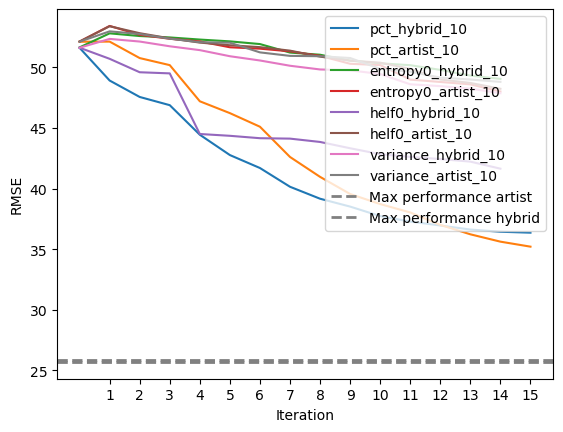

In [220]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
pct_artist_10= [52.1141, 52.1250, 50.7658, 50.1841, 47.2005, 46.2233, 45.1015, 42.6064, 40.9643, 39.5504, 38.7188, 38.0271, 37.0007, 36.2239, 35.6175, 35.2048]
baseline_artist = 25.6939
pct_hybrid_10= [51.6109, 48.9135, 47.5573, 46.8794, 44.4417, 42.7638, 41.6943, 40.1471, 39.1606, 38.5109, 37.7270, 37.2760, 36.9515, 36.6174, 36.4348, 36.3588]
baseline_hybrid = 25.8557

# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_hybrid_10)), pct_hybrid_10, label='pct_hybrid_10')
ax1.plot(np.arange(len(pct_artist_10)), pct_artist_10, label='pct_artist_10')
ax1.plot(np.arange(len(entropy0_hybrid[0])), entropy0_hybrid[0], label='entropy0_hybrid_10')
ax1.plot(np.arange(len(entropy0_artist_10[0])), entropy0_artist_10[0], label='entropy0_artist_10')
ax1.plot(np.arange(len(helf0_hybrid[0])), helf0_hybrid[0], label='helf0_hybrid_10')
ax1.plot(np.arange(len(helf0_artist_10[0])), helf0_artist_10[0], label='helf0_artist_10')
ax1.plot(np.arange(len(variance_hybrid[0])), variance_hybrid[0], label='variance_hybrid_10')
ax1.plot(np.arange(len(variance_artist_10[0])), variance_artist_10[0], label='variance_artist_10')
ax1.axhline(y=baseline_artist, color='gray', linestyle='--', linewidth=2, label='Max performance artist')
ax1.axhline(y=baseline_hybrid, color='gray', linestyle='--', linewidth=2, label='Max performance hybrid')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()

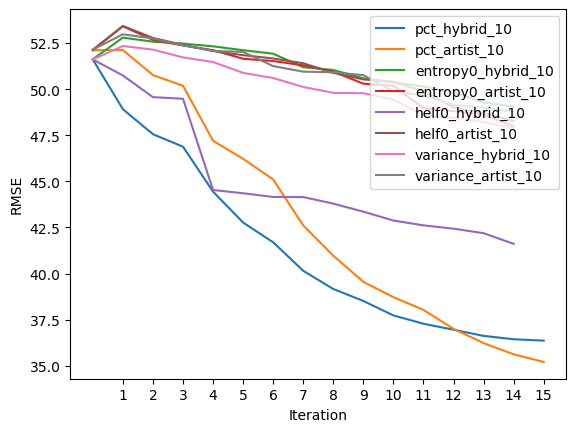

In [244]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_hybrid_10[0])), pct_hybrid_10[0], label='pct_hybrid_10')
ax1.plot(np.arange(len(pct_artist_10[0])), pct_artist_10[0], label='pct_artist_10')
ax1.plot(np.arange(len(entropy0_hybrid[0])), entropy0_hybrid[0], label='entropy0_hybrid_10')
ax1.plot(np.arange(len(entropy0_artist_10[0])), entropy0_artist_10[0], label='entropy0_artist_10')
ax1.plot(np.arange(len(helf0_hybrid[0])), helf0_hybrid[0], label='helf0_hybrid_10')
ax1.plot(np.arange(len(helf0_artist_10[0])), helf0_artist_10[0], label='helf0_artist_10')
ax1.plot(np.arange(len(variance_hybrid[0])), variance_hybrid[0], label='variance_hybrid_10')
ax1.plot(np.arange(len(variance_artist_10[0])), variance_artist_10[0], label='variance_artist_10')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()

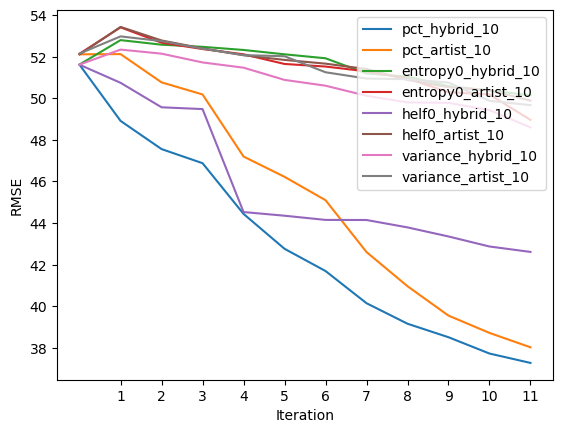

In [242]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(12), pct_hybrid_10[0][:12], label='pct_hybrid_10')
ax1.plot(np.arange(12), pct_artist_10[0][:12], label='pct_artist_10')
ax1.plot(np.arange(12), entropy0_hybrid[0][:12], label='entropy0_hybrid_10')
ax1.plot(np.arange(12), entropy0_artist_10[0][:12], label='entropy0_artist_10')
ax1.plot(np.arange(12), helf0_hybrid[0][:12], label='helf0_hybrid_10')
ax1.plot(np.arange(12), helf0_artist_10[0][:12], label='helf0_artist_10')
ax1.plot(np.arange(12), variance_hybrid[0][:12], label='variance_hybrid_10')
ax1.plot(np.arange(12), variance_artist_10[0][:12], label='variance_artist_10')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 12)) 
plt.show()

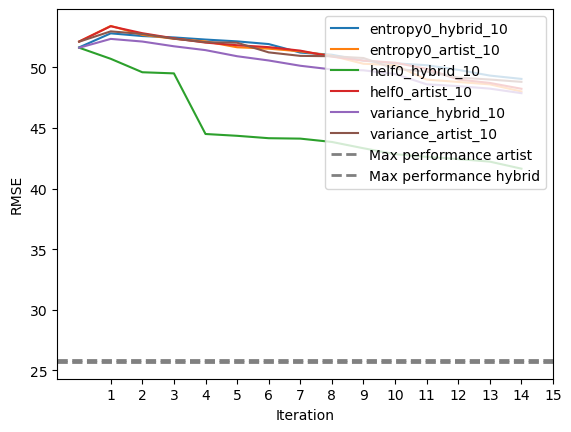

In [222]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
baseline_artist = 25.6939
baseline_hybrid = 25.8557
# fig.suptitle('Horizontally stacked subplots')
# ax1.plot(np.arange(len(pct_hybrid_10[0])), pct_hybrid_10[0], label='pct_hybrid_10')
# ax1.plot(np.arange(len(pct_artist_10[0])), pct_artist_10[0], label='pct_artist_10')
ax1.plot(np.arange(len(entropy0_hybrid[0])), entropy0_hybrid[0], label='entropy0_hybrid_10')
ax1.plot(np.arange(len(entropy0_artist_10[0])), entropy0_artist_10[0], label='entropy0_artist_10')
ax1.plot(np.arange(len(helf0_hybrid[0])), helf0_hybrid[0], label='helf0_hybrid_10')
ax1.plot(np.arange(len(helf0_artist_10[0])), helf0_artist_10[0], label='helf0_artist_10')
ax1.plot(np.arange(len(variance_hybrid[0])), variance_hybrid[0], label='variance_hybrid_10')
ax1.plot(np.arange(len(variance_artist_10[0])), variance_artist_10[0], label='variance_artist_10')
ax1.axhline(y=baseline_artist, color='gray', linestyle='--', linewidth=2, label='Max performance artist')
ax1.axhline(y=baseline_hybrid, color='gray', linestyle='--', linewidth=2, label='Max performance hybrid')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()

## 20% warm

In [75]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.2)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")


In [76]:
train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")

In [77]:
# shape of test_cold

print(f"Cold users in X: {len(np.unique(X_cold_artist.nonzero()[0]))}")
print(f"Cold items in X: {len(np.unique(X_cold_artist.nonzero()[1]))}")
print(f"test users in test: {len(np.unique(test_cold_artist.nonzero()[0]))}")
print(f"test items in test: {len(np.unique(test_cold_artist.nonzero()[1]))}")
print(f"train users in train: {len(np.unique(train_cold_K_artist.nonzero()[0]))}")
print(f"train items in train: {len(np.unique(train_cold_K_artist.nonzero()[1]))}")

print("-------------------")

# shape of test_cold
print(f"Shape of test_cold: {test_cold_artist.shape}")
print(f"Shape of train_cold: {train_cold_K_artist.shape}")
print(f"Shape of X_cold: {X_cold_artist.shape}")

Cold users in X: 1361
Cold items in X: 4793
test users in test: 1322
test items in test: 3777
train users in train: 588
train items in train: 510
-------------------
Shape of test_cold: (1361, 5011)
Shape of train_cold: (1361, 5011)
Shape of X_cold: (1361, 5011)


In [58]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_20 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.2930
MAE:  45.1202
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.2144
MAE:  45.0390
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.6760
MAE:  44.4549
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.4298
MAE:  44.1917
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.1970
MAE:  43.9442
✅ Iteration 4 complete.

🔁 Iteration 5/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.9571
MAE:  43.6777
✅ Iteration 5 complete.

🔁 Iteration 6/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.7175
MAE:  43.4183
✅ Iteration 6 complete.

🔁 Iteration 7/7 (skip asked items, walk from root)


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  weights = 1/var
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/utils.py:47: UserWarning: At least one of the target variables is constant, setting its weight to 0.
  warnings.warn("At least one of the target variables is constant, setting its weight to 0.")


Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.1466
MAE:  42.8111
✅ Iteration 7 complete.


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore runtime warnings

pct_hybrid_20 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

In [ ]:
entropy0_hybrid_20 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=15,
    k=1,
    positive=False
)

In [ ]:
entropy0_artist_20 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=15,
    k=1,
    positive=False
)

In [ ]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_hybrid_20[0])), pct_hybrid_20[0], label='pct_hybrid_20')
ax1.plot(np.arange(len(pct_artist_20[0])), pct_artist_20[0], label='pct_artist_20')
ax1.plot(np.arange(len(entropy0_hybrid_20[0])), entropy0_hybrid_20[0], label='entropy0_hybrid_20')
ax1.plot(np.arange(len(entropy0_artist_20[0])), entropy0_artist_20[0], label='entropy0_artist_20')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()

## 30% warm

In [ ]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.3)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")


In [ ]:
train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_30 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore runtime warnings

pct_hybrid_30 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

In [ ]:
entropy0_hybrid_30 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=15,
    k=1,
    positive=False
)

In [ ]:
entropy0_artist_30 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=15,
    k=1,
    positive=False
)

In [ ]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_hybrid_30[0])), pct_hybrid_30[0], label='pct_hybrid_30')
ax1.plot(np.arange(len(pct_artist_30[0])), pct_artist_30[0], label='pct_artist_30')
ax1.plot(np.arange(len(entropy0_hybrid_30[0])), entropy0_hybrid_30[0], label='entropy0_hybrid_30')
ax1.plot(np.arange(len(entropy0_artist_30[0])), entropy0_artist_30[0], label='entropy0_artist_30')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()

## 40% warm

In [117]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.4)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")


In [118]:
train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")

In [125]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_40 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.8862
MAE:  45.1049
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.5470
MAE:  43.7099
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.8641
MAE:  42.9904
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.4838
MAE:  42.5968
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.1626
MAE:  42.251

C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 48.7934
MAE:  40.8279
✅ Iteration 7 complete.


In [126]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore runtime warnings

pct_hybrid_40 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.5665
MAE:  44.8128
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.2072
MAE:  43.3985
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 49.7757
MAE:  41.8970
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 49.1967
MAE:  41.2901
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 48.5019
MAE:  40.568

C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 46.9158
MAE:  38.9219
✅ Iteration 7 complete.


In [120]:
entropy0_hybrid_40 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 52.5594
MAE:  44.8034
RMSE: 54.3153
MAE:  48.4950
1
RMSE: 54.1340
MAE:  48.2835
2
RMSE: 53.2387
MAE:  47.3045
3
RMSE: 53.0119
MAE:  47.0583
4
RMSE: 52.9425
MAE:  46.9835
5
RMSE: 52.7320
MAE:  46.7486
6
RMSE: 52.6844
MAE:  46.7006
7


In [123]:
entropy0_artist_40 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 52.8911
MAE:  45.1130
RMSE: 54.7381
MAE:  48.8887
1
RMSE: 54.4716
MAE:  48.6113
2
RMSE: 54.2356
MAE:  48.3537
3
RMSE: 53.6274
MAE:  47.6893
4
RMSE: 53.4382
MAE:  47.4823
5
RMSE: 53.3805
MAE:  47.4230
6
RMSE: 53.0868
MAE:  47.0983
7


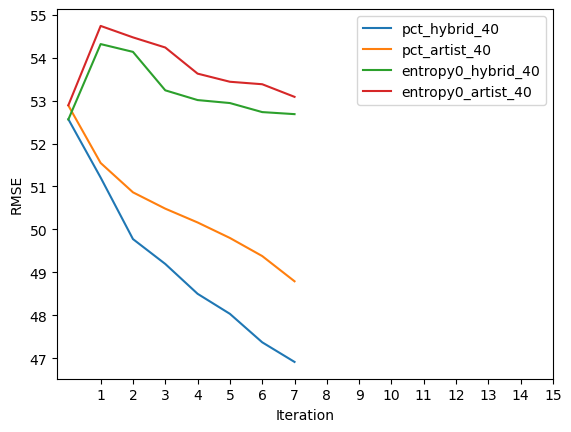

In [129]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_hybrid_40[0])), pct_hybrid_40[0], label='pct_hybrid_40')
ax1.plot(np.arange(len(pct_artist_40[0])), pct_artist_40[0], label='pct_artist_40')
ax1.plot(np.arange(len(entropy0_hybrid_40[0])), entropy0_hybrid_40[0], label='entropy0_hybrid_40')
ax1.plot(np.arange(len(entropy0_artist_40[0])), entropy0_artist_40[0], label='entropy0_artist_40')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()

## 50% warm

In [131]:
warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, 0.5)

df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating")


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")


In [132]:
train_cold_K_artist, X_cold_artist, test_cold_artist  = split_and_combine("artist-only")
train_cold_K_hybrid, X_cold_hybrid, test_cold_hybrid = split_and_combine("hybrid")

In [135]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_artist_50 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.4136
MAE:  44.2066
✅ Baseline evaluation complete.

🔁 Iteration 1/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.1646
MAE:  43.9463
✅ Iteration 1 complete.

🔁 Iteration 2/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 51.9096
MAE:  43.6948
✅ Iteration 2 complete.

🔁 Iteration 3/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.0129
MAE:  41.7256
✅ Iteration 3 complete.

🔁 Iteration 4/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 49.7832
MAE:  41

C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 47.4991
MAE:  39.1326
✅ Iteration 7 complete.

🔁 Iteration 8/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...


KeyboardInterrupt: 

In [138]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# ignore runtime warnings

pct_hybrid_50 = elicitation_by_tree_path_retrain_skiped_warm(
    Tree=Tree,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=7
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 52.5876
MAE:  44.3082
✅ Baseline evaluation complete.

🔁 Iteration 1/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.3628
MAE:  44.0828
✅ Iteration 1 complete.

🔁 Iteration 2/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 52.0987
MAE:  43.8177
✅ Iteration 2 complete.

🔁 Iteration 3/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 50.2659
MAE:  41.9419
✅ Iteration 3 complete.

🔁 Iteration 4/7 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 48.5152
MAE:  40.140

C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
C:\Users/13447/Documents/GitHub/master_thesis\pct\tree\node\node.py:73: RuntimeWarning: invalid value encountered in d

✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 45.2953
MAE:  36.8618
✅ Iteration 7 complete.


In [150]:
entropy0_hybrid_50 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_hybrid,
    test=test_cold_hybrid,
    X=X_cold_hybrid,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 52.6020
MAE:  44.3255
RMSE: 56.3339
MAE:  50.7332
1
RMSE: 56.2250
MAE:  50.6153
2
RMSE: 56.1966
MAE:  50.5809
3
RMSE: 55.6527
MAE:  49.9914
4
RMSE: 55.4116
MAE:  49.7265
5
RMSE: 54.9699
MAE:  49.2498
6
RMSE: 54.7460
MAE:  49.0016
7


In [151]:
entropy0_artist_50 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K_artist,
    test=test_cold_artist,
    X=X_cold_artist,
    strategy=i_entropy_0,
    iteration=8,
    k=1,
    positive=False
)

RMSE: 52.3870
MAE:  44.1766
RMSE: 56.0645
MAE:  50.5030
1
RMSE: 55.9706
MAE:  50.3909
2
RMSE: 55.8643
MAE:  50.2798
3
RMSE: 55.8981
MAE:  50.3055
4
RMSE: 55.6360
MAE:  50.0161
5
RMSE: 55.1846
MAE:  49.5163
6
RMSE: 55.0955
MAE:  49.4268
7


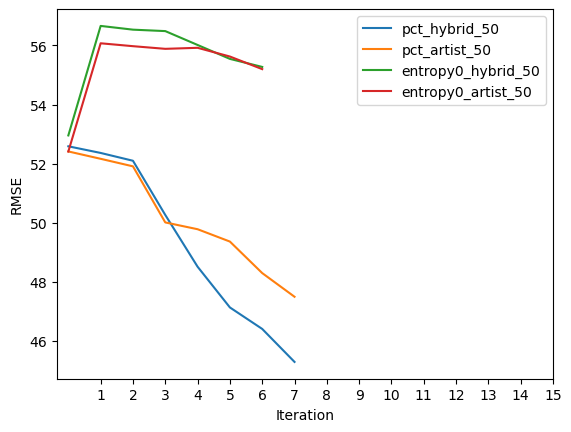

In [148]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
pct_artist_50 = [52.4136,
  52.1646,
  51.9096,
  50.0129,
  49.7832,
  49.3656,
  48.2997,
  47.4991]

# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_hybrid_50[0])), pct_hybrid_50[0], label='pct_hybrid_50')
# ax1.plot(np.arange(len(pct_artist_50[0])), pct_artist_50[0], label='pct_artist_50')
ax1.plot(np.arange(len(pct_artist_50)), pct_artist_50, label='pct_artist_50')
ax1.plot(np.arange(len(entropy0_hybrid_50[0])), entropy0_hybrid_50[0], label='entropy0_hybrid_50')
ax1.plot(np.arange(len(entropy0_artist_50[0])), entropy0_artist_50[0], label='entropy0_artist_50')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()

### all entropy 

In [ ]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(entropy0_hybrid[0])), entropy0_hybrid[0], label='entropy0_hybrid_10')
ax1.plot(np.arange(len(entropy0_artist_10[0])), entropy0_artist_10[0], label='entropy0_artist_10')
ax1.plot(np.arange(len(entropy0_hybrid_20[0])), entropy0_hybrid_20[0], label='entropy0_hybrid_20')
ax1.plot(np.arange(len(entropy0_artist_20[0])), entropy0_artist_20[0], label='entropy0_hybrid_20')
ax1.plot(np.arange(len(entropy0_hybrid_30[0])), entropy0_hybrid_30[0], label='entropy0_hybrid_30')
ax1.plot(np.arange(len(entropy0_artist_30[0])), entropy0_artist_30[0], label='entropy0_hybrid_30')
ax1.plot(np.arange(len(entropy0_hybrid_40[0])), entropy0_hybrid_40[0], label='entropy0_hybrid_40')
ax1.plot(np.arange(len(entropy0_artist_40[0])), entropy0_artist_40[0], label='entropy0_hybrid_40')
ax1.plot(np.arange(len(entropy0_hybrid_50[0])), entropy0_hybrid_50[0], label='entropy0_hybrid_50')
ax1.plot(np.arange(len(entropy0_artist_50[0])), entropy0_artist_50[0], label='entropy0_hybrid_50')
# ax1.plot(x, pct_2[0], label='pct_2'

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()

### all pct

In [ ]:
# x = np.arange(0,16) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(np.arange(len(pct_hybrid_10[0])), pct_hybrid_10[0], label='pct_hybrid_10')
ax1.plot(np.arange(len(pct_artist_10[0])), pct_artist_10[0], label='pct_artist_10')
ax1.plot(np.arange(len(pct_hybrid_20[0])), pct_hybrid_20[0], label='pct_hybrid_20')
ax1.plot(np.arange(len(pct_artist_20[0])), pct_artist_20[0], label='pct_artist_20')
ax1.plot(np.arange(len(pct_hybrid_30[0])), pct_hybrid_30[0], label='pct_hybrid_30')
ax1.plot(np.arange(len(pct_artist_30[0])), pct_artist_30[0], label='pct_artist_30')
ax1.plot(np.arange(len(pct_hybrid_40[0])), pct_hybrid_40[0], label='pct_hybrid_40')
ax1.plot(np.arange(len(pct_artist_40[0])), pct_artist_40[0], label='pct_artist_40')
ax1.plot(np.arange(len(pct_hybrid_50[0])), pct_hybrid_50[0], label='pct_hybrid_50')
ax1.plot(np.arange(len(pct_artist_50[0])), pct_artist_50[0], label='pct_artist_50')


plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 16)) 
plt.show()